In [1]:
from scipy.io import netcdf
import numpy
from davitpy.pydarn.radar import *
from davitpy.pydarn.plotting import *
from davitpy.utils import *
import netCDF4
import cdf
import pandas
import aacgmv2
from davitpy import utils
%pylab inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plot', 'pylab', 'figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
inpFN18 = "../data/processed/F18/20141216.txt"
inpFN17 = "../data/processed/F17/20141216.txt"
inpFN16 = "../data/processed/F16/20141216.txt"
inpTime = datetime.datetime(2014,12,16,21,0)

In [3]:
ssusiDF18 = pandas.read_csv( inpFN18, delim_whitespace=True,\
                                infer_datetime_format=True,\
                                parse_dates=["date"] )
ssusiDF17 = pandas.read_csv( inpFN17, delim_whitespace=True,\
                                infer_datetime_format=True,\
                                parse_dates=["date"] )
ssusiDF16 = pandas.read_csv( inpFN16, delim_whitespace=True,\
                                infer_datetime_format=True,\
                                parse_dates=["date"] )
ssusiDF = pandas.concat( [ssusiDF18, ssusiDF17, ssusiDF16] )
ssusiDF = ssusiDF.fillna(0.)

In [4]:
# get min and max times in each orbit
orbitMin = ssusiDF[ ["date", "sat", "orbitNum"] ].groupby(["orbitNum", "sat"]).min().reset_index()
orbitMin.columns = [ "orbitNum", "sat", "date_min" ]
orbitMax = ssusiDF[ ["date", "sat", "orbitNum"] ].groupby(["orbitNum", "sat"]).max().reset_index()
orbitMax.columns = [ "orbitNum", "sat", "date_max" ]
orbitDF = pandas.merge( orbitMin, orbitMax, on=["orbitNum", "sat"] )
# get orbit corresponding to selected input time
selOrbit = orbitDF[ (orbitDF["date_min"] <= inpTime) &\
                 (orbitDF["date_max"] >= inpTime)\
                  ].reset_index(drop=True)
print selOrbit

   orbitNum  sat                   date_min                   date_max
0     26617  F18 2014-12-16 19:40:20.000383 2014-12-16 21:22:14.000906
1     41874  F17 2014-12-16 19:39:15.000611 2014-12-16 21:21:06.000494
2     57595  F16 2014-12-16 20:52:47.000303 2014-12-16 22:34:38.000727


In [5]:
# Now merge the two DFs to only select data
# from the orbit of interest
ssusiDF = ssusiDF.merge( selOrbit, on=[ "orbitNum", "sat" ] )
ssusiDF.head()

,date,sat,orbitNum,mlat.1,mlat.2,mlat.3,mlat.4,mlat.5,mlat.6,mlat.7,...,dlbhl.35,dlbhl.36,dlbhl.37,dlbhl.38,dlbhl.39,dlbhl.40,dlbhl.41,dlbhl.42,date_min,date_max
0,2014-12-16 19:40:20.000383,F18,26617,41.49,41.53,41.53,41.52,41.50,41.46,41.43,...,-2.87,-1.90,-6.48,0.0,0.0,0.0,0.0,0.0,2014-12-16 19:40:20.000383,2014-12-16 21:22:14.000906
1,2014-12-16 19:40:24.000132,F18,26617,41.74,41.78,41.78,41.77,41.75,41.72,41.69,...,-1.75,242.98,-3.33,0.0,0.0,0.0,0.0,0.0,2014-12-16 19:40:20.000383,2014-12-16 21:22:14.000906
2,2014-12-16 19:40:27.000881,F18,26617,41.98,42.03,42.04,42.03,42.01,41.98,41.95,...,-0.47,-1.72,-3.11,0.0,0.0,0.0,0.0,0.0,2014-12-16 19:40:20.000383,2014-12-16 21:22:14.000906
3,2014-12-16 19:40:31.000630,F18,26617,42.22,42.28,42.29,42.28,42.27,42.24,42.21,...,0.00,-0.23,-2.65,0.0,0.0,0.0,0.0,0.0,2014-12-16 19:40:20.000383,2014-12-16 21:22:14.000906
4,2014-12-16 19:40:35.000379,F18,26617,42.46,42.52,42.54,42.54,42.52,42.50,42.47,...,66.21,170.12,57.43,0.0,0.0,0.0,0.0,0.0,2014-12-16 19:40:20.000383,2014-12-16 21:22:14.000906


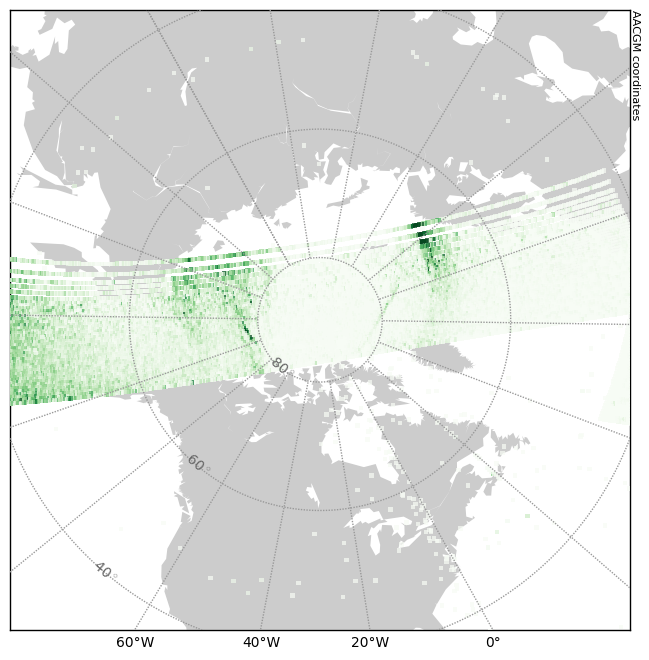

In [6]:
ssusiMlats18 = ssusiDF[ ssusiDF["sat"] == "F18" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('mlat')\
                ]].values
ssusiMlons18 = ssusiDF[ ssusiDF["sat"] == "F18" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('mlon')\
                ]].values
ssusiDisk18 = ssusiDF[ ssusiDF["sat"] == "F18" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('d135')\
                ]].values
    
ssusiMlats17 = ssusiDF[ ssusiDF["sat"] == "F17" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('mlat')\
                ]].values
ssusiMlons17 = ssusiDF[ ssusiDF["sat"] == "F17" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('mlon')\
                ]].values
ssusiDisk17 = ssusiDF[ ssusiDF["sat"] == "F17" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('d135')\
                ]].values
    
ssusiMlats16 = ssusiDF[ ssusiDF["sat"] == "F16" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('mlat')\
                ]].values
ssusiMlons16 = ssusiDF[ ssusiDF["sat"] == "F16" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('mlon')\
                ]].values
ssusiDisk16 = ssusiDF[ ssusiDF["sat"] == "F16" ]\
                [ssusiDF.columns[pandas.Series(\
                ssusiDF.columns).str.startswith('d135')\
                ]].values    
    

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
m = plotUtils.mapObj(boundinglat=40., coords='mag')
xVec18, yVec18 = m(ssusiMlons18, ssusiMlats18, coords="mag")
p = m.scatter(xVec18, yVec18, c=ssusiDisk18, s=10.,\
           cmap="Greens", alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=1000.)

xVec17, yVec17 = m(ssusiMlons17, ssusiMlats17, coords="mag")

# p = m.scatter(xVec17, yVec17, c=ssusiDisk17, s=10.,\
#            cmap="Greens", alpha=0.7, zorder=5., \
#                      edgecolor='none', marker="s", vmin=0., vmax=1000.)

# p = m.pcolormesh(xVec, yVec, ssusiDisk18, zorder=1.9,
#                         vmin=0, vmax=1000,
#                         ax=ax, alpha=1, cmap='Greens')

p.set_rasterized(True)

fig.savefig("../figs/ssusi-test-18.pdf",bbox_inches='tight')

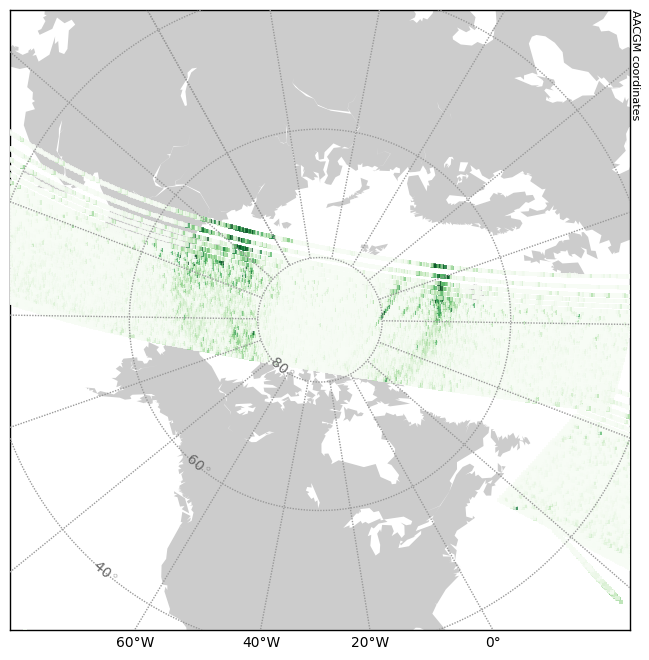

In [7]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
m = plotUtils.mapObj(boundinglat=40., coords='mag')

p = m.scatter(xVec17, yVec17, c=ssusiDisk17, s=10.,\
           cmap="Greens", alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=1000.)

# p = m.pcolormesh(xVec17, yVec17, ssusiDisk17, zorder=1.9,
#                         vmin=0, vmax=1000,
#                         ax=ax, alpha=1, cmap='Greens')

p.set_rasterized(True)

fig.savefig("../figs/ssusi-test-17.pdf",bbox_inches='tight')

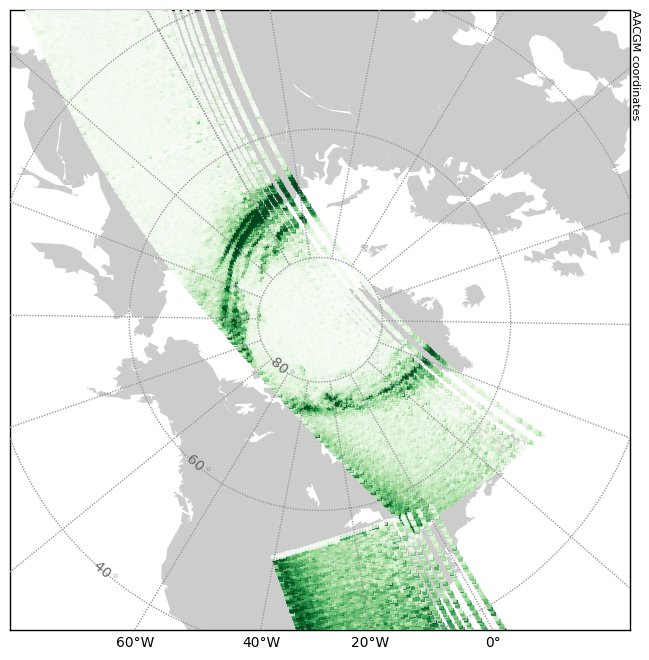

In [8]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1,1,1)
m = plotUtils.mapObj(boundinglat=40., coords='mag')

xVec16, yVec16 = m(ssusiMlons16, ssusiMlats16, coords="mag")

p = m.scatter(xVec16, yVec16, c=ssusiDisk16, s=10.,\
           cmap="Greens", alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=1000.)

# p = m.pcolormesh(xVec17, yVec17, ssusiDisk17, zorder=1.9,
#                         vmin=0, vmax=1000,
#                         ax=ax, alpha=1, cmap='Greens')

p.set_rasterized(True)

fig.savefig("../figs/ssusi-test-16.pdf",bbox_inches='tight')

In [25]:
ssusiDF = ssusiDF.round()
mlonList = []
mlatList = []
mltList = []
d121List = []
d130List = []
d135List = []
dLBHSList = []
dLBHLList = []
# for currMlon in range(-180,181):
#     for currMlat in range(-90, 91):
print ssusiDF[ ["mlat.1", "mlon.1"] ].head()

   mlat.1  mlon.1
0    41.0    89.0
1    42.0    89.0
2    42.0    89.0
3    42.0    89.0
4    42.0    89.0


In [48]:
def get_col_name(row):    
    b = (df.ix[row.name] == row['value'])
    return b.index[b.argmax()]

evalStrMLAT = "(ssusiDF['{0}'] == " + str( int(42.) ) + ".)"
evalStrMLON = "(ssusiDF['{0}'] == " + str( int(89.) ) + ".)"
filterColMlat = [col for col in ssusiDF if col.startswith('mlat')]
filterColMlon = [col for col in ssusiDF if col.startswith('mlon')]
x = ssusiDF[eval("(" + " | ".join([\
            evalStrMLAT.format(col) 
            for col in filterColMlat] ) +\
        ") & ("  + " | ".join([\
            evalStrMLON.format(col) 
            for col in filterColMlon] ) + ")")\
           ].reset_index(drop=True)
print x

                         date  sat  orbitNum  mlat.1  mlat.2  mlat.3  mlat.4  \
0  2014-12-16 19:40:20.000383  F18     26617    41.0    42.0    42.0    42.0   
1  2014-12-16 19:40:24.000132  F18     26617    42.0    42.0    42.0    42.0   
2  2014-12-16 19:40:27.000881  F18     26617    42.0    42.0    42.0    42.0   
3  2014-12-16 19:40:31.000630  F18     26617    42.0    42.0    42.0    42.0   
4  2014-12-16 19:40:35.000379  F18     26617    42.0    43.0    43.0    43.0   
5  2014-12-16 19:40:39.000128  F18     26617    43.0    43.0    43.0    43.0   
6  2014-12-16 19:40:42.000877  F18     26617    43.0    43.0    43.0    43.0   
7  2014-12-16 19:40:46.000626  F18     26617    43.0    43.0    43.0    43.0   
8  2014-12-16 19:40:50.000375  F18     26617    43.0    44.0    44.0    44.0   
9  2014-12-16 19:40:54.000124  F18     26617    44.0    44.0    44.0    44.0   
10 2014-12-16 19:40:57.000873  F18     26617    44.0    44.0    44.0    44.0   
11 2014-12-16 19:41:01.000622  F18     2

In [42]:
print "(" + " | ".join(["1", "2", "3"] ) + ") & ("  + " | ".join(["a", "b", "c"] ) + ")"

(1 | 2 | 3) & (a | b | c)


In [46]:
print "(" + " | ".join([\
            evalStrMLAT.format(col) 
            for col in filterColMlat] ) +\
        ") & ("  + " | ".join([\
            evalStrMLON.format(col) 
            for col in filterColMlon] ) + ")"

((ssusiDF['mlat.1'] == 42.) | (ssusiDF['mlat.2'] == 42.) | (ssusiDF['mlat.3'] == 42.) | (ssusiDF['mlat.4'] == 42.) | (ssusiDF['mlat.5'] == 42.) | (ssusiDF['mlat.6'] == 42.) | (ssusiDF['mlat.7'] == 42.) | (ssusiDF['mlat.8'] == 42.) | (ssusiDF['mlat.9'] == 42.) | (ssusiDF['mlat.10'] == 42.) | (ssusiDF['mlat.11'] == 42.) | (ssusiDF['mlat.12'] == 42.) | (ssusiDF['mlat.13'] == 42.) | (ssusiDF['mlat.14'] == 42.) | (ssusiDF['mlat.15'] == 42.) | (ssusiDF['mlat.16'] == 42.) | (ssusiDF['mlat.17'] == 42.) | (ssusiDF['mlat.18'] == 42.) | (ssusiDF['mlat.19'] == 42.) | (ssusiDF['mlat.20'] == 42.) | (ssusiDF['mlat.21'] == 42.) | (ssusiDF['mlat.22'] == 42.) | (ssusiDF['mlat.23'] == 42.) | (ssusiDF['mlat.24'] == 42.) | (ssusiDF['mlat.25'] == 42.) | (ssusiDF['mlat.26'] == 42.) | (ssusiDF['mlat.27'] == 42.) | (ssusiDF['mlat.28'] == 42.) | (ssusiDF['mlat.29'] == 42.) | (ssusiDF['mlat.30'] == 42.) | (ssusiDF['mlat.31'] == 42.) | (ssusiDF['mlat.32'] == 42.) | (ssusiDF['mlat.33'] == 42.) | (ssusiDF['mlat.34'